### GSE Concentration

In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5
import os

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

<ipython-input-42-b1c8549607aa>:8: RuntimeWarning: invalid value encountered in sqrt
  ax[0].plot(vc2_2['R'], np.sqrt(vc2_2['disk']), label='disk')
<ipython-input-42-b1c8549607aa>:13: RuntimeWarning: invalid value encountered in sqrt
  ax[1].plot(vc2_5['R'], np.sqrt(vc2_5['vc2']), c='k', label='tot')
<ipython-input-42-b1c8549607aa>:15: RuntimeWarning: invalid value encountered in sqrt
  ax[1].plot(vc2_5['R'], np.sqrt(vc2_5['disk']), label='disk')


(0.0, 100.0)

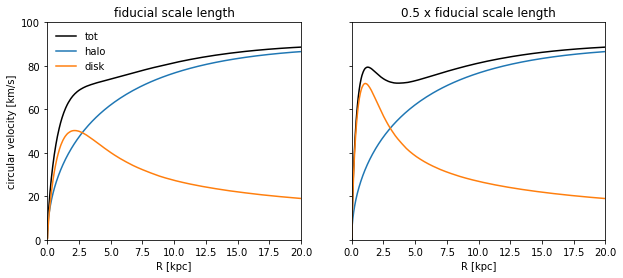

In [42]:
vc2_2 = np.genfromtxt(basepath+'ics/GSE2iso_fg0.7/lvl4/GSE_ICs.vci', names=True)
vc2_5 = np.genfromtxt(basepath+'ics/GSE5iso_fg0.7/lvl4/GSE_ICs.vci', names=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax[0].plot(vc2_2['R'], np.sqrt(vc2_2['vc2']), c='k', label='tot')
ax[0].plot(vc2_2['R'], np.sqrt(vc2_2['halo']), label='halo')
ax[0].plot(vc2_2['R'], np.sqrt(vc2_2['disk']), label='disk')
ax[0].set_title('fiducial scale length')
ax[0].legend(frameon=False)
ax[0].set(xlim=(0, 20), ylim=(0, 100), xlabel='R [kpc]', ylabel='circular velocity [km/s]')

ax[1].plot(vc2_5['R'], np.sqrt(vc2_5['vc2']), c='k', label='tot')
ax[1].plot(vc2_5['R'], np.sqrt(vc2_5['halo']), label='halo')
ax[1].plot(vc2_5['R'], np.sqrt(vc2_5['disk']), label='disk')
ax[1].set_title('0.5 x fiducial scale length')
ax[1].set(xlim=(0, 20), ylim=(0, 100), xlabel='R [kpc]')
plt.ylim(0, 100)

<ipython-input-27-5a61f83514d0>:5: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(vc2_3['R'], np.sqrt(vc2_3['disk']), label='disk')


(0.0, 100.0)

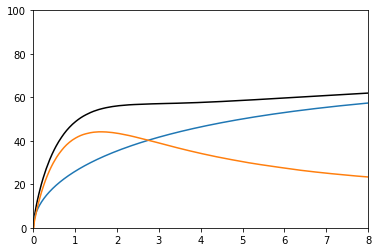

In [27]:
vc2_3 = np.genfromtxt(basepath+'ics/GSE3iso_fg0.7/lvl4/GSE_ICs.vci', names=True)

plt.plot(vc2_3['R'], np.sqrt(vc2_3['vc2']), c='k', label='tot')
plt.plot(vc2_3['R'], np.sqrt(vc2_3['halo']), label='halo')
plt.plot(vc2_3['R'], np.sqrt(vc2_3['disk']), label='disk')
plt.xlim(0, 8)
plt.ylim(0, 100)

<ipython-input-35-7286a6bf5da1>:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(vc2_3['R'], np.sqrt(vc2_3['vc2']), c='k', label='tot')
<ipython-input-35-7286a6bf5da1>:5: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(vc2_3['R'], np.sqrt(vc2_3['disk']), label='disk')


(0.0, 100.0)

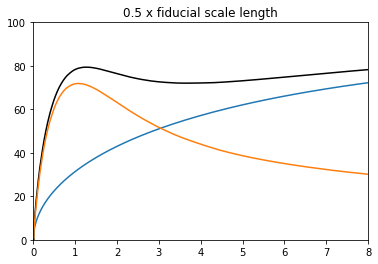

In [35]:
vc2_3 = np.genfromtxt(basepath+'ics/GSE5iso_fg0.7/lvl4/GSE_ICs.vci', names=True)

plt.plot(vc2_3['R'], np.sqrt(vc2_3['vc2']), c='k', label='tot')
plt.plot(vc2_3['R'], np.sqrt(vc2_3['halo']), label='halo')
plt.plot(vc2_3['R'], np.sqrt(vc2_3['disk']), label='disk')
plt.title('0.5 x fiducial scale length')
plt.xlim(0, 8)
plt.ylim(0, 100)

(0.0, 100.0)

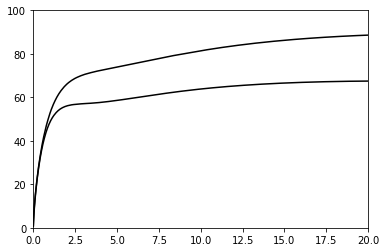

In [18]:
plt.plot(vc2_2['R'], np.sqrt(vc2_2['vc2']), c='k', label='GSE2')
plt.plot(vc2_3['R'], np.sqrt(vc2_3['vc2']), c='k', label='GSE3')
plt.xlim(0, 20)
plt.ylim(0, 100)

In [25]:
ics = arepo.Snapshot(basepath + 'ics/GSE3iso_fg0.7/lvl4/GSE_ICs.dat')

mbar = 7.5E3 * 8 / 1E10
mdm = 3.75E4 * 8 / 1E10


Mgas = ics.NumPart_Total[0] * ics.MassTable[0]
print('Ngas = ', Mgas/mbar)

MDM = ics.NumPart_Total[1] * ics.MassTable[1]
print('NDM = ', MDM/mdm)

Mstar = ics.NumPart_Total[2] * ics.MassTable[2]
print('Nstar = ', Mstar/mbar)


Ngas =  11444.329759608596
NDM =  323711.04177178605
Nstar =  4904.7127541179725


In [26]:
print(ics.MassTable)

[6.00017289e-06 3.00000039e-05 5.99964863e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


### core formation in isolation

In [4]:
sn = {}
num_list = [0, 100, 200, 300, 400, 500]
for num in num_list:
    sn[num] = arepo.Snapshot(basepath + 'runs/GSE2iso_fg0.7/lvl4/output', 
                             num, combineFiles=True)


In [12]:
def get_halo_profile(sn):
    cen = sn.part1.pos.value[np.argmin(sn.part1.pot.value)]
    pos = sn.part1.pos.value
    r = np.linalg.norm(pos - cen, axis=1)
    
    rmin = 0.
    dr = 0.2
    
    rave = []
    rho = []
    
    while rmin < 50:
        key = np.logical_and(r >= rmin, r < rmin + dr)
        
        rave.append(np.mean(r[key]))
        mass_in = len(np.where(key)[0]) * sn.MassTable[1].value
        vol = (4*np.pi/3.) * ((rmin+dr)**3 - rmin**3)
        rho.append(mass_in/vol)
        
        rmin += dr
    
    return np.array(rave), np.array(rho)

In [13]:
rave = {}
rho = {}
for num in num_list:
    rave[num], rho[num] = get_halo_profile(sn[num])

Text(0, 0.5, 'rho [1E10 Msun/kpc^3]')

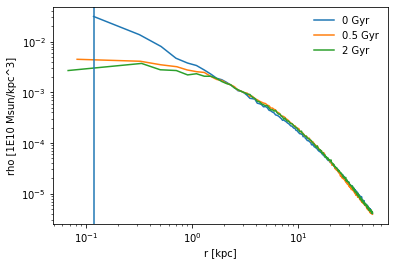

In [33]:
plt.plot(rave[0], rho[0], label='0 Gyr')
plt.plot(rave[100], rho[100], label='0.5 Gyr')
plt.plot(rave[400], rho[400], label='2 Gyr')
plt.legend(frameon=False)
# plt.xlim(0, 40)
plt.yscale('log')
plt.xscale('log')
# plt.axvline(sn[0].parameters.SofteningComovingType1)
plt.axvline(3*sn[0].parameters.SofteningComovingType1)
plt.xlabel('r [kpc]')
plt.ylabel('rho [1E10 Msun/kpc^3]')

In [28]:
sn[0].parameters.SofteningComovingType1

0.04